In [208]:
import os
import getpass

from utils import *
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Flatten, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import pickle

#Sklearn 
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, plot_confusion_matrix, roc_curve, auc

plt.style.use('ggplot')

In [209]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
classes = {'coast':0,'forest':1,'highway':2,'inside_city':3,'mountain':4,'Opencountry':5,'street':6,'tallbuilding':7}

Num GPUs Available:  1


In [210]:
train_images_filenames = pickle.load(open('../train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../test_images_filenames.dat','rb'))
train_images_filenames = ['../..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['../..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../train_labels.dat','rb'))
test_labels = pickle.load(open('../test_labels.dat','rb'))

# Model Training

We will first start by training the best possible Neural Network. To do so we can play on a lot of parameters : Input image size, number of layers, number of neurons per layer, ... This neural network will be our basis to feed learnt features to a SVM model later on, we thus will try to optimize it as much as we can.

The code below was run with different parameters in order to train competing models.

In [211]:
TRAIN = False
#user defined variables
IMG_SIZE    = 128
BATCH_SIZE  = 256
EPOCHS = 25

#DATASET_DIR = '/home/mcv/datasets/MIT_split'
#MODEL_FNAME = '/home/group01/work/my_first_mlp.h5'
DATASET_DIR = '../../MIT_split'
MODEL_FNAME = '../../my_first_mlp.h5'

In [212]:
if not os.path.exists(DATASET_DIR):
  print(Color.RED, 'ERROR: dataset directory '+DATASET_DIR+' do not exists!\n')

In [213]:
if TRAIN:
    print('Building MLP model...\n')

    #Build the Multi Layer Perceptron model
    model = Sequential()
    model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=2048, activation='relu',name='second'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=1024, activation='relu', name='third'))
    model.add(Dropout(0.2))
    model.add(Dense(units=512, activation='relu', name='fourth'))
    model.add(Dense(units=256, activation='relu', name='fifth'))
    model.add(Dense(units=8, activation='softmax'))

    optimizer = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    print(model.summary())
    #plot_model(model, to_file='modelMLP.png', show_shapes=True, show_layer_names=True)

    print('Done!\n')

In [214]:
if TRAIN:
    if os.path.exists(MODEL_FNAME):
        print('WARNING: model file '+MODEL_FNAME+' exists and will be overwritten!\n')
        model.load_weights(MODEL_FNAME)

    print('Start training...\n')

    # this is the dataset configuration we will use for training
    # only rescaling
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True, 
            rotation_range=10, # rotation
            width_shift_range=0.2, # horizontal shift
            height_shift_range=0.2, # vertical shift
            brightness_range=[0.7,1.2]) # brightness)
            

    # this is the dataset configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            DATASET_DIR+'/train',  # this is the target directory
            target_size=(IMG_SIZE, IMG_SIZE),  # all images will be resized to IMG_SIZExIMG_SIZE
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            DATASET_DIR+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')

    history = model.fit(
            train_generator,
            steps_per_epoch=1881 // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=807 // BATCH_SIZE)

    print('Done!\n')
    print('Saving the model into '+MODEL_FNAME+' \n')
    model.save_weights(MODEL_FNAME)  # always save your weights after training or during training
    print('Done!\n')

In [215]:
if TRAIN :
    colorprint(Color.GREEN, "Accuracy on the training set : " + str(round(np.mean(history.history["accuracy"][-10:]),3)) + "\n")
    colorprint(Color.BLUE , "Accuracy on the test set : " + str(round(np.mean(history.history["val_accuracy"][-10:]) ,3)) )

In [216]:
if TRAIN:
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('accuracy.jpg')
    #plt.close()
    # summarize history for loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('loss.jpg')

***

## Experiments and model improvement

Here are the results of the different experiements we tried in order to get the best possible Neural Netwotrk : 

### Metric

In order to compare the performances of the different models we are going to train, we need to choose a metric. The metric we decided to use is the mean accuracy of the model on the last 10 epochs of the training phase, both on the traing and on the test set. The higher the accuracy is, the best the model is to predict which scene the image is taken from.

___ 

### Experiment 1 : Number of layers

The first experiment we wanted to conduct was to see the importance of the number of dense layers in the model. We chose a reference image size of $128 \times 128$ that is gonna be the same for every model, as well as a Batch Size of $256$. Models will be trained for $100$-$200$ epochs. 

The different models that we are going to try are the following :
- $model_1$ : 1 layer -> 2048
- $model_2$ : 2 layers -> 2048-1024
- $model_3$ : 3 layers -> 2048-1024-512
- $model_4$ : 4 layers -> 2048-1024-512-256
- $model_5$ : 5 layers -> 2048-1024-512-256-128

**Expected Results :** We expect that adding more layers would improve accuracy. 

The results we obtained are the following : 

<center>

| Model name | Training Accuracy | Validation Accuracy |
|:---------:|:---------:|:---------:|
| $model_1$  | 0.724 | 0.572 |
| $model_2$  | 0.823 | 0.608 |
| $model_3$  | **0.909** | 0.613 |
| $model_4$  | 0.905 | **0.620** |
| $model_5$  | 0.895 | 0.617 |

</center>

**Conclusion :**
> We notice that increasing the number of layers improves the accuracy on the training and validation images. We can also note that bigger models tend to overfit more than the smaller ones. Regularization techniques will be furtherly applied to try to reduce this effect. After the $4\ layers$ model, performance seems to stagnate. For th following experiments, we will use the $2048 \times 1024 \times 512 \times 256$ model. 

.

One Layer          |  Two Layers | Three Layers          |  Four Layers
:-------------------------:|:-------------------------: | :-------------------------:|:-------------------------:
![](images/accuracy_1_layer.jpg)  |  ![](images/accuracy_2_layer.jpg) |![](images/accuracy_3_layer.jpg)  |  ![](images/accuracy_4_layer.jpg)
![](images/loss_1_layer.jpg)  |  ![](images/loss_2_layer.jpg) |![](images/loss_3_layer.jpg)  |  ![](images/loss_4_layer.jpg)

![]() 
<center>
<img src="images/nb_layers.png" width="800" align="center"/>
</center>

___

### Experiment 2 : Input Image size

The second experiment we wanted to try was to see how input image size would improve or decrease performance. All the models will be trained for 150 epochs. For the last experiment, we've been using $128 \times 128$ images, here we will try our previous best performing model with the following input image sizes :

- $model_{32}$ : $32 \times 32$ images
- $model_{64}$ : $64 \times 64$ images
- $model_{128}$ : $128 \times 128$ images
- $model_{180}$ : $180 \times 180$ images

**Expected Results :** We expect that higher image resolution would improve accuracy. 

<center>

| Model name | Training Accuracy | Validation Accuracy |
|:---------:|:---------:|:---------:|
| $model_{32}$  | 0.716 | 0.567 |
| $model_{64}$ | 0.765 | 0.586 |
| $model_{128}$  | 0.906 | **0.624** |
| $model_{180}$  | **0.931** | 0.620 |

</center>

**Conclusion :**
> We notice that increasing image size does improve performance as expected. We also notice that further than $128 \times 128$, increasing the image size doesn't improve validation accuracy but does increase the overtraining gap. For the following experiments the $128 \times 128$ image size will be our default one.

![]() 
<center>
<img src="images/img_size.png" width="800" align="center"/>
</center>


___
### Experiment 3 : Augmentations and model tweaking

On this final experiment, we will see if Data Augmentation and other common techniques could improve the performances of our model. For the previous experiments, the model was only made of Dense layers and the only augmentation method used was the horizontal_flip. The different techniques we are going to try are the following : 

- Augmentation : Rotation 
- Augmentation : Rotation + Sihft
- Augmentation : Rotation + Sihft + Brightness
- Batch Normalization 
- Dropout 

<center>

| Model name | Training Accuracy | Validation Accuracy |
|:---------:|:---------:|:---------:|
| Rotation  | 0.930 | 0.629 |
| Brightness  | 0.925 | 0.584 |
| Rotation + Shift + Brightness  | 0.776 | **0.701** |
| Dropout  | 0.821 | 0.625 |
| Batch Normalisation  | **0.995** | 0.639 |
| **All** | 0.799 | 0.698 |

</center>

**Conclusion :** 
> Using augmentation techniques is showing very promising results as we obtained one of our best score with (Rotation + Shift + Brightness). Data Augmentation Techniques also help a lot in reducing the overfitting gap. The only problem we encountered with this techniques is the increased number of epochs necessary to converge. Our model with the three augmentation techniques combined had to be trained for 500 epochs.  

> We thought that adding Dropout layers would force the model to use a bigger number of neurons and thus reduce the overfitting gap. Without showing incredible results or improving validation accuracy, it still helped reducing the overfitting gap.

> Batch Normalization helped imroving the validation accuracy, but was first and foremost super effective at reducing the number of epochs needed to converge.

___

# Analysis

### Trained models against previous techniques

Here we will compare the performances of an end-to-end MLP against the performances of a SVM classifier trained on the features learned by this same MLP.


#### End to end Multi-Layer Perceptron

After training a Neural Network with the code above, we will benchmark the performances of this model on our test dataset.

In [217]:
#Build the Multi Layer Perceptron model
IMG_SIZE = 128
model = Sequential()
model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(units=2048, activation='relu',name='second'))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu', name='third'))
#model.add(Dropout(0.2))
model.add(Dense(units=512, activation='relu', name='fourth'))
model.add(Dense(units=256, activation='relu', name='fifth'))
model.add(Dense(units=8, activation='softmax'))

In [218]:
#Load Model Weight
MODEL_LOAD_NAME = '../../my_first_mlp_128x128_all.h5'
model.load_weights(MODEL_LOAD_NAME)

In [219]:
directory = DATASET_DIR+'/test'

correct = 0
total   = 807
count   = 0

for imname, label in zip(test_images_filenames, test_labels):
    im = np.asarray(Image.open(os.path.join(imname)))/255
    im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
    cls = classes[label]
    out = model.predict(im)
    predicted_cls = np.argmax( out )
    if predicted_cls == cls:
        correct+=1
    count += 1
    print('Evaluated images: '+str(count)+' / '+str(total), end='\r')
    
colorprint(Color.BLUE, 'Done!\n')
colorprint(Color.GREEN, 'Test Acc. = '+str(correct/total)+'\n')

Done!images: 807 / 807
Test Acc. = 0.6988847583643123


### SVM Classifier with learnt features

Now that we checked the performance of our best end-to-end MLP as a classifier, we will try to see if we could get better performances by using the MLP as a feature extraxctor and leaving the classification part to a SVM algorithm.

We will first start by extracting features for every images of our dataset.

In [220]:
model_layer = Model(inputs=model.input, outputs=model.get_layer('third').output)
layer_preds = []
layer_classes = []

In [221]:
if not os.path.exists("train_layer_preds.pkl"):

    #We will start by creating features training sets
    count, total = 0, 1881

    for imname, label in zip(train_images_filenames, train_labels):
        im = np.asarray(Image.open(os.path.join(imname)))
        im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
        cls = classes[label]

        layer_preds.append(model_layer.predict(im))
        layer_classes.append(cls)
    
        count += 1
        print('Added images: '+ str(count)+' / '+str(total), end='\r')

    X_train = np.vstack(layer_preds)
    y_train = np.array(layer_classes)
    
    with open("train_layer_preds.pkl", "wb") as f: 
        pickle.dump(X_train, f)
    with open("train_layer_preds_classes.pkl", "wb") as f:
        pickle.dump(y_train, f)

else:
    X_train = pickle.load(open("train_layer_preds.pkl","rb"))
    y_train = pickle.load(open("train_layer_preds_classes.pkl","rb"))


In [222]:

if not os.path.exists("test_layer_preds.pkl"):

    layer_preds = []
    layer_classes = []

    #We will start by creating features training sets
    count, total = 0, 807

    for imname, label in zip(test_images_filenames, test_labels):
        im = np.asarray(Image.open(os.path.join(imname)))
        im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
        cls = classes[label]

        layer_preds.append(model_layer.predict(im))
        layer_classes.append(cls)
    
        count += 1
        print('Added images: '+ str(count)+' / '+str(total), end='\r')

    X_test = np.vstack(layer_preds)
    y_test = np.array(layer_classes)
    
    with open("test_layer_preds.pkl", "wb") as f: 
        pickle.dump(X_test, f)
    with open("test_layer_preds_classes.pkl", "wb") as f:
        pickle.dump(y_test, f)

else:
    X_test = pickle.load(open("test_layer_preds.pkl","rb"))
    y_test = pickle.load(open("test_layer_preds_classes.pkl","rb"))

In [223]:
#Define SVM Model and scaler
svm_model = svm.SVC()
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.transform(X_test)

#Fit the SVM model to the training data
svm_model.fit(X_train, y_train)

#Get the predictions for the training and test sets
svm_train_preds = svm_model.predict(X_train)
svm_test_preds = svm_model.predict(X_test)

#Get accuracy score
colorprint(Color.GREEN, f"Accuracy on the training set : {round(accuracy_score(y_train, svm_train_preds),3)} \n")
colorprint(Color.BLUE , f"Accuracy on the test set : {round(accuracy_score(y_test, svm_test_preds),3)}")


Accuracy on the training set : 0.79 
Accuracy on the test set : 0.698

Once we extracted the features, we only need to fit the SVM model on the training set and evaluates its performances on the features extracted from the 
test set. 

After getting this baseline score, we try to improve our model performances by searching the optimal hyperparameters through a grid search.

In [224]:
svc = svm.SVC() 
svm_grid = GridSearchCV(svc, {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1e-1, 1, 10, 20]}, cv=8, 
                    scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)

svm_grid.fit(X_train, y_train)
print(svm_grid.best_params_)

#Define an optimized SVM Model and scaler
svm_model = svm.SVC(kernel=svm_grid.best_params_["kernel"], C=svm_grid.best_params_["C"])
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.transform(X_test)

#Fit the SVM model to the training data
svm_model.fit(X_train, y_train)

#Get the predictions for the training and test sets
svm_train_preds = svm_model.predict(X_train)
svm_test_preds = svm_model.predict(X_test)

#Get accuracy score
colorprint(Color.GREEN, f"Accuracy on the training set : {round(accuracy_score(y_train, svm_train_preds),3)} \n")
colorprint(Color.BLUE , f"Accuracy on the test set : {round(accuracy_score(y_test, svm_test_preds),3)}")


{'C': 10, 'kernel': 'rbf'}
Accuracy on the training set : 0.97 
Accuracy on the test set : 0.713

Each layer of the Neural Network could be used as a feature extractor. First layers should represent high level features whereas the following ones are a combination of previous features and should thus be more complex. 

It is impossible to know which layer should be used as a feature extractor, which is why we decided to lead the following experiment :


<center>

| Model name | Training Accuracy | Validation Accuracy | Optimal Parameters |
|:---------:|:---------:|:---------:|:---------:|
| First Layer  | 0.909 | 0.673 | poly kernel, C=10 |
| Second Layer | 0.970 | 0.713 | rbf kernel, C=10 |
| Third Layer  | 0.964 | 0.709 | rbf kernel, C=10 | 
| Fourth Layer  | 0.812 | 0.698 | rbf kernel, C=1 |

</center>

**Conclusion :**
> The best results we obtained were with the second and the third layers.

> Using MLP as a feature extractor and SVM as a classifier yields slightly better results than the end-to-end Neural Network classifier.  


### Beyond SVM : Random Forest

In [225]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier( )
rf_grid = GridSearchCV(rf, {'n_estimators':[100,200,500]}, cv=8, 
                    scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)

rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

#Define an optimized SVM Model and scaler
rf_model = RandomForestClassifier(n_estimators=rf_grid.best_params_["n_estimators"])
scaler = StandardScaler()

#scaler.fit_transform(X_train)
#scaler.transform(X_test)

#Fit the SVM model to the training data
rf_model.fit(X_train, y_train)

#Get the predictions for the training and test sets
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

#Get accuracy score
colorprint(Color.GREEN, f"Accuracy on the training set : {round(accuracy_score(y_train, rf_train_preds),3)} \n")
colorprint(Color.BLUE , f"Accuracy on the test set : {round(accuracy_score(y_test, rf_test_preds),3)}")

{'n_estimators': 200}
Accuracy on the training set : 0.999 
Accuracy on the test set : 0.675

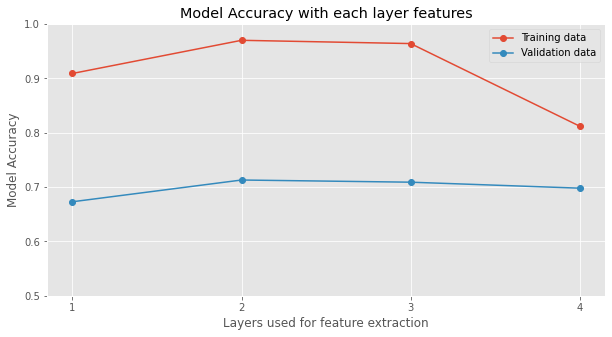

In [226]:
X = [1,2,3,4]
train = [0.909 , 0.970, 0.964, 0.812]
test = [0.673 , 0.713 , 0.709, 0.698]
plt.figure(figsize=(10,5))
plt.plot(X, train, linestyle="solid", marker="o", label="Training data")
plt.plot(X, test, linestyle="solid", marker="o", label="Validation data")
plt.title("Model Accuracy with each layer features")
plt.xlabel("Layers used for feature extraction")
plt.ylabel("Model Accuracy")
plt.xticks([1,2,3,4])
plt.ylim(0.5,1)
plt.legend()
plt.savefig("images/svm_layers.png", dpi=250)